# Análise de Classificação - Previsão e Detecção de Risco de Crédito

Este projeto tem como objetivo apenas para fins educacionais, com intuito de praticar todo o conhecimento adquirido no curso de Machine Learning da formação Cientista de Dados, ministrado pela Data Science Academy. Este projeto foi fornecido como exemplo em linguagem R durante o curso, e fiz a conversão para linguagem Python para praticar. Neste exemplo, foi ensinado apenas a regressão logística, porém, nesse jupyter notebook conterá todo o conhecimento adquirido por mim durante o curso.

## Definindo o Problema de Negócio

O objetivo deste projeto é desenvolver um sistema de Previsão e Detecção de Risco de Crédito que possa auxiliar instituições financeiras na avaliação de pedidos de empréstimos baseado nas informações contidas no dataset. Baseado nessas informações, o modelo irá avaliar se aprovará o emprestimo (sim - 1) ou não aprovará o emprestimo (não - 0)

O dataset foi disponibilizado pela Data Sciende Academy.

## Carregando pacotes e Dataset

In [1]:
# Importando pacotes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline 

In [2]:
# Carregando dataset
df = pd.read_csv('dados/credit_dataset_final.csv')
df.head()

,credit.rating,account.balance,credit.duration.months,previous.credit.payment.status,credit.purpose,credit.amount,savings,employment.duration,installment.rate,marital.status,...,residence.duration,current.assets,age,other.credits,apartment.type,bank.credits,occupation,dependents,telephone,foreign.worker
0,1,1,18,3,2,1049,1,1,4,1,...,4,2,21,2,1,1,3,1,1,1
1,1,1,9,3,4,2799,1,2,2,3,...,2,1,36,2,1,2,3,2,1,1
2,1,2,12,2,4,841,2,3,2,1,...,4,1,23,2,1,1,2,1,1,1
3,1,1,12,3,4,2122,1,2,3,3,...,2,1,39,2,1,2,2,2,1,2
4,1,1,12,3,4,2171,1,2,4,3,...,4,2,38,1,2,2,2,1,1,2


In [3]:
# Coletando X e y
X = df.iloc[:, 1:]
y = df['credit.rating']

# Gerando número de observações e variáveis
observasoes = len(df)
variaveis = df.columns[1:]

## Análise Exploratória

Nesa etapa iremos plotar alguns gráficos para entender melhor os dados, realizar algumas análises e observar como estão distribuidos.

**A variável target está banaceada?**

Não, Será necessário aplicar alguma técnica de balanceamento na variável target.

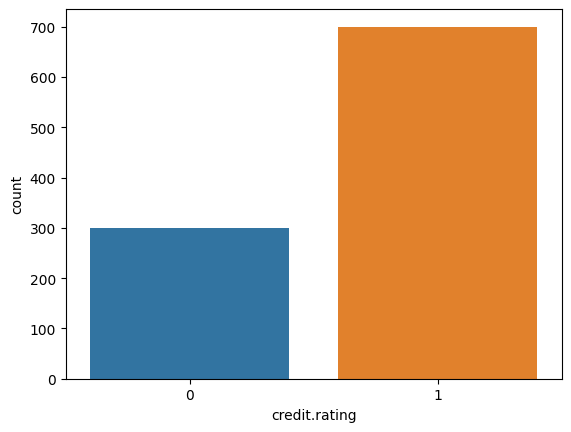

In [4]:
sns.countplot(df, x= 'credit.rating')
plt.show()

## Balanceamento da Variável Target

In [5]:
# Gerando dados sintéticos da classe minoritária
smote = SMOTE(random_state= 42)
X, y = smote.fit_resample(X, y)

# Shape
print('Shape do dataset %s' % Counter(y))

Shape do dataset Counter({1: 700, 0: 700})


## Feature Scaling

Usaremos a técnica de **padronização** para deixar os dados numéricos contínuos na mesma escala.

In [6]:
# Selecionando as variáveis numéricas contínuas
var_num = ['credit.duration.months', 'age', 'credit.amount']

# Aplicando padronização
scaler = StandardScaler()
X[var_num] = scaler.fit_transform(X[var_num])

## Seleção de Variáveis

Nesta etapa vamos criar um gráfico para visualizarmos se há forte correlação entre as variáveis, e logo em seguida, avaliaremos se há variáveis com multicolinearidade utilizando autovalores e autovetores. Também utilizaremos o RandomForest para verificar quais variáveis são as mais importantes para o modelo.

### Análise de Correlação

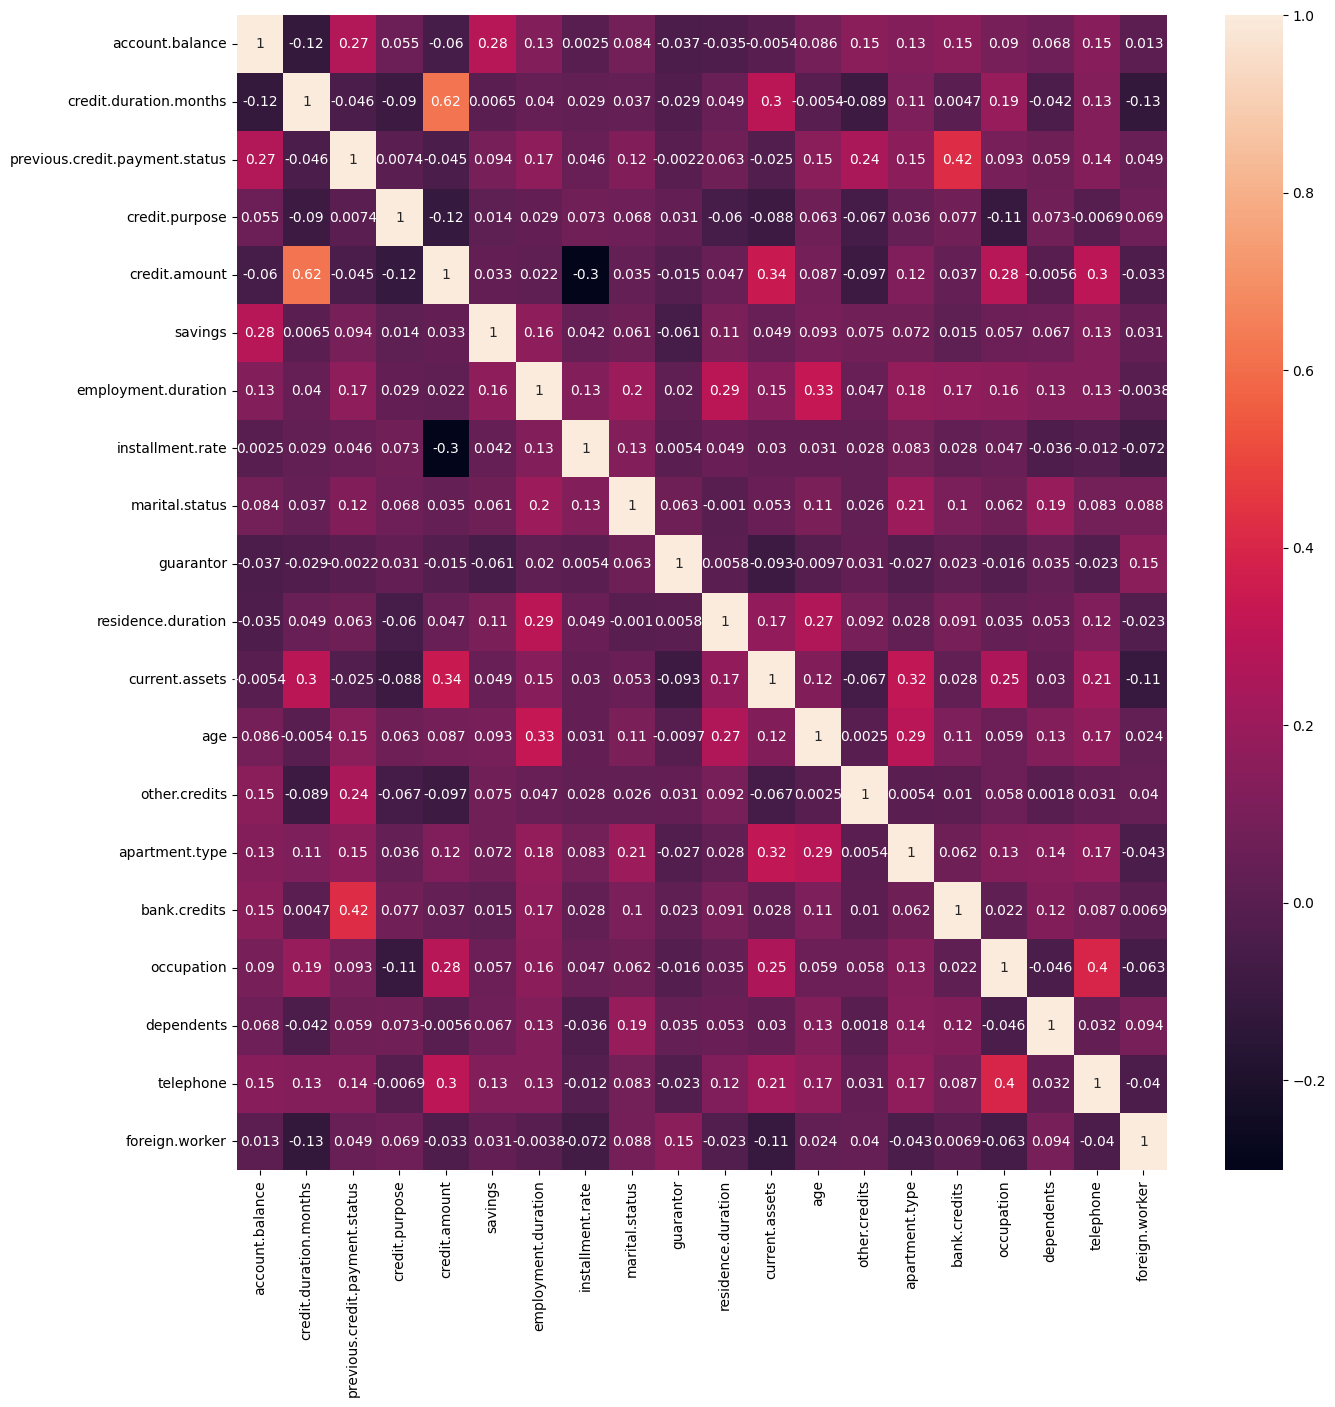

In [7]:
# Criando matriz de correlação
matriz_corr = X.corr()

# Definindo tamanho do gráfico
plt.figure(figsize= (15, 15))

# Plot
sns.heatmap(matriz_corr, annot= True)
plt.show()

In [8]:
# Gerando autovalores e autovetores
corr = np.corrcoef(X, rowvar = 0)
autovalores, autovetores = np.linalg.eig(corr)

In [9]:
print(autovalores)

[2.7490527  2.15060181 1.38957148 0.25832588 1.30851882 1.19700823
 1.14010534 1.11198316 0.47259932 0.51136472 0.52796821 0.60028429
 0.98631114 0.95170869 0.66728539 0.69214294 0.86405228 0.77405565
 0.8285285  0.81853144]


In [10]:
print(autovetores[:,3])

[ 0.00158099  0.56302539 -0.06802126 -0.01731543 -0.7283358   0.02217316
 -0.04002728 -0.31556196  0.03887058  0.01388291 -0.03078003  0.07126339
  0.09510484 -0.00093242 -0.02852861  0.06199382  0.07300098 -0.0163896
  0.12804425  0.05001419]


In [12]:
print(variaveis[4], variaveis[7], )

credit.amount installment.rate


As variáveis **credit.amount e installment.rate** são responsáveis pela multicoliniaridade no dataset.

### Random Forest

In [13]:
# Criando o modelo
selec_feature = RandomForestClassifier(n_estimators= 100)

# Treinando o modelo
selec_feature.fit(X, y)

# Extraindo a importância
importances = selec_feature.feature_importances_
indices = np.argsort(importances)

# Buscando os nomes das colunas
labels = X.columns

# Obtém os índices
ind = []

for i in indices:
    ind.append(labels[i])

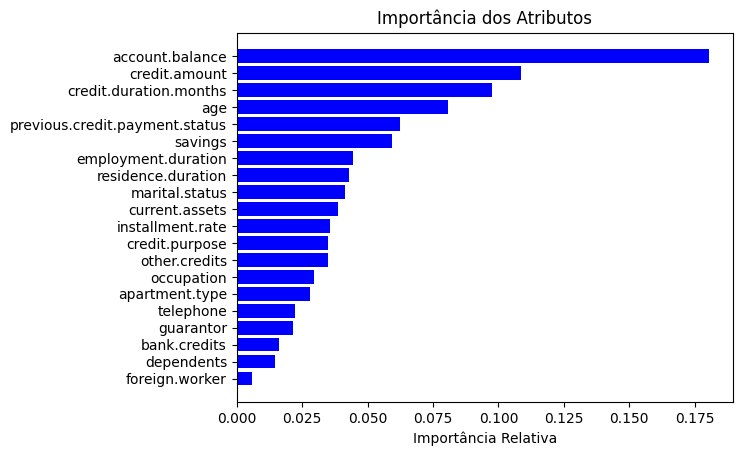

In [14]:
# Plot da Importância dos Atributos
plt.figure(1)
plt.title('Importância dos Atributos')
plt.barh(range(len(indices)), importances[indices], color= 'b', align= 'center')
plt.yticks(range(len(indices)), ind)
plt.xlabel('Importância Relativa')
plt.show()

## Treinamento do Modelo

### Regressão Logística

In [15]:
# Divisão de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

# Treinando o modelo
modelo_lr_v1 = LogisticRegression()
modelo_lr_v1.fit(X_train, y_train)

# Previsões
y_pred = modelo_lr_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.7952380952380952
Matriz de Confusão:
[[171  38]
 [ 48 163]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       209
           1       0.81      0.77      0.79       211

    accuracy                           0.80       420
   macro avg       0.80      0.80      0.80       420
weighted avg       0.80      0.80      0.80       420



## K-Nearest Neighbor

In [16]:
# Divisão em dados de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [17]:
# Divisão dos dados de treino em dados de treino e dados de validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)

In [18]:
# Número de registros em cada dataset
print("Registros de Treino: {}".format(len(X_train)))
print("Registros de Validação: {}".format(len(X_val)))
print("Registros de Teste: {}".format(len(X_test)))

Registros de Treino: 1008
Registros de Validação: 112
Registros de Teste: 280


In [19]:
# Range de valores de k
kVals = range(1, 30, 2)

# Lista para receber o valor de acurácia
acuracias = []

# Loop em todos os valores de k para testar cada um deles
for k in kVals:
    
    # Treinando o modelo KNN com cada valor de k
    modeloKNN = KNeighborsClassifier(n_neighbors = k)
    modeloKNN.fit(X_train, y_train)
          
    # Avaliando o modelo e atualizando a lista de acurácias
    score = modeloKNN.score(X_val, y_val)
    print("Com valor de k = %d, a acurácia é = %.2f%%" % (k, score * 100))
    acuracias.append(score)

Com valor de k = 1, a acurácia é = 83.93%
Com valor de k = 3, a acurácia é = 82.14%
Com valor de k = 5, a acurácia é = 81.25%
Com valor de k = 7, a acurácia é = 80.36%
Com valor de k = 9, a acurácia é = 83.93%
Com valor de k = 11, a acurácia é = 83.04%
Com valor de k = 13, a acurácia é = 83.93%
Com valor de k = 15, a acurácia é = 84.82%
Com valor de k = 17, a acurácia é = 83.93%
Com valor de k = 19, a acurácia é = 84.82%
Com valor de k = 21, a acurácia é = 84.82%
Com valor de k = 23, a acurácia é = 83.93%
Com valor de k = 25, a acurácia é = 83.93%
Com valor de k = 27, a acurácia é = 83.04%
Com valor de k = 29, a acurácia é = 83.93%


In [20]:
# Obtendo o valor de k que apresentou a maior acurácia
i = np.argmax(acuracias)
print("O valor de k = %d alcançou a mais alta acurácia de %.2f%% nos dados de validação!" % (kVals[i], 
                                                                                             acuracias[i] * 100))

O valor de k = 15 alcançou a mais alta acurácia de 84.82% nos dados de validação!


**Primeira Versão**

In [21]:
# Criando a versão final do modelo com o maior valor de k
modelo_knn_v1 = KNeighborsClassifier(n_neighbors = kVals[i])

# Treinamento do modelo
modelo_knn_v1.fit(X_train, y_train)

# Previsões com os dados de teste
y_pred = modelo_knn_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.7857142857142857
Matriz de Confusão:
[[113  18]
 [ 42 107]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       131
           1       0.86      0.72      0.78       149

    accuracy                           0.79       280
   macro avg       0.79      0.79      0.79       280
weighted avg       0.80      0.79      0.79       280



**Segunda Versão**

In [22]:
# Criando a versão final do modelo com o maior valor de k
modelo_knn_v2 = KNeighborsClassifier(n_neighbors = kVals[i])

param = {'weights': ['uniform', 'distance'], 
         'p': [1, 2, 3, 4, 5], 
         'metric': ['euclidean', 'manhattam', 'minkowski']}

grid_search = GridSearchCV(modelo_knn_v2, param_grid= param, cv= 5, scoring= 'accuracy', n_jobs= 3)

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

# Os melhores parâmetros
top_param = grid_search.best_params_
print("Melhores hiperparâmetros encontrados:", top_param)

# Treinando com o melhor modelo
modelo_knn_v2 = grid_search.best_estimator_

# Previsões com os dados de teste
y_pred = modelo_knn_v2.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Melhores hiperparâmetros encontrados: {'metric': 'minkowski', 'p': 1, 'weights': 'distance'}
Acurácia: 0.8107142857142857
Matriz de Confusão:
[[111  20]
 [ 33 116]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       131
           1       0.85      0.78      0.81       149

    accuracy                           0.81       280
   macro avg       0.81      0.81      0.81       280
weighted avg       0.81      0.81      0.81       280



### Naive Bayes BernoulliNB

In [23]:
# Divisão de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

# Treinando o modelo
modelo_nb_v1 = BernoulliNB()
modelo_nb_v1.fit(X_train, y_train)

# Previsões com os dados de teste
y_pred = modelo_nb_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.5928571428571429
Matriz de Confusão:
[[107 109]
 [ 62 142]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.63      0.50      0.56       216
           1       0.57      0.70      0.62       204

    accuracy                           0.59       420
   macro avg       0.60      0.60      0.59       420
weighted avg       0.60      0.59      0.59       420



### Decision Tree Classifier

In [24]:
# Instânciando o modelo
modelo_decisionTree_v1 = DecisionTreeClassifier(max_depth = None, 
                                                max_features = None, 
                                                criterion = 'gini', 
                                                min_samples_leaf = 1, 
                                                min_samples_split = 2)

# Treinando o modelo
modelo_decisionTree_v1.fit(X_train, y_train)

# Previsões com os dados de teste
y_pred = modelo_decisionTree_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.7523809523809524
Matriz de Confusão:
[[168  48]
 [ 56 148]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       216
           1       0.76      0.73      0.74       204

    accuracy                           0.75       420
   macro avg       0.75      0.75      0.75       420
weighted avg       0.75      0.75      0.75       420



### Random Forest Classifier

**Primeira Versão**

In [25]:
# Instanciando o modelo
modelo_randomForest_v1 = RandomForestClassifier(n_estimators= 100, 
                                                max_depth = 15, 
                                                max_features = 5, 
                                                criterion = 'gini', 
                                                min_samples_leaf = 1, 
                                                min_samples_split = 2)

# Treinando o modelo
modelo_randomForest_v1.fit(X_train, y_train)

# Previsões com os dados de teste
y_pred = modelo_randomForest_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.819047619047619
Matriz de Confusão:
[[184  32]
 [ 44 160]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       216
           1       0.83      0.78      0.81       204

    accuracy                           0.82       420
   macro avg       0.82      0.82      0.82       420
weighted avg       0.82      0.82      0.82       420



**Segunda Versão**

In [26]:
# Instanciando o modelo
modelo_randomForest_v2 = RandomForestClassifier()

# Definindo os parâmetros
param = {'max_depth': [None, 3, 5, 10, 20], 
         'n_estimators': [300, 500, 1000, 3000],
         'max_features': [1, 3, 10], 
         'min_samples_leaf': [1, 3, 10], 
         'bootstrap': [True, False], 
         'criterion': ['gini', 'entropy']}

grid_search = GridSearchCV(modelo_randomForest_v2, param_grid= param, cv= 5, scoring= 'accuracy', n_jobs= 3)

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

# Os melhores parâmetros
top_param = grid_search.best_params_
print("Melhores hiperparâmetros encontrados:", top_param)

# Treinando com o melhor modelo
modelo_randomForest_v2 = grid_search.best_estimator_

# Previsões com os dados de teste
y_pred = modelo_randomForest_v2.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Melhores hiperparâmetros encontrados: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 1, 'min_samples_leaf': 1, 'n_estimators': 500}
Acurácia: 0.8428571428571429
Matriz de Confusão:
[[185  31]
 [ 35 169]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       216
           1       0.84      0.83      0.84       204

    accuracy                           0.84       420
   macro avg       0.84      0.84      0.84       420
weighted avg       0.84      0.84      0.84       420



### Bagging Classifier

**Primeira Versão**

In [27]:
# Instanciando o modelo
modelo_bagging_v1 = BaggingClassifier(KNeighborsClassifier(), n_estimators= 100, max_samples = 0.5, max_features = 0.5)

# Treinando o modelo
modelo_bagging_v1.fit(X_train, y_train)

# Previsões com os dados de teste
y_pred = modelo_bagging_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.8095238095238095
Matriz de Confusão:
[[184  32]
 [ 48 156]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       216
           1       0.83      0.76      0.80       204

    accuracy                           0.81       420
   macro avg       0.81      0.81      0.81       420
weighted avg       0.81      0.81      0.81       420



**Segunda Versão**

In [29]:
# Instanciando o modelo
modelo_bagging_v2 = BaggingClassifier(KNeighborsClassifier())

# Parâmetros
param = {'n_estimators': [200, 500, 1000, 3000], 
       'max_samples': [0.3, 0.5, 0.8], 
       'max_features': [0.3, 0.5, 0.8], 
       'bootstrap': [True, False], 
       }

grid_search = GridSearchCV(modelo_bagging_v2, param_grid= param, cv= 5, scoring= 'accuracy', n_jobs= 3)

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

# Os melhores parâmetros
top_param = grid_search.best_params_
print("Melhores hiperparâmetros encontrados:", top_param)

# Treinando com o melhor modelo
modelo_bagging_v2 = grid_search.best_estimator_

# Previsões com os dados de teste
y_pred = modelo_bagging_v2.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Melhores hiperparâmetros encontrados: {'bootstrap': True, 'max_features': 0.5, 'max_samples': 0.8, 'n_estimators': 200}
Acurácia: 0.8261904761904761
Matriz de Confusão:
[[184  32]
 [ 41 163]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       216
           1       0.84      0.80      0.82       204

    accuracy                           0.83       420
   macro avg       0.83      0.83      0.83       420
weighted avg       0.83      0.83      0.83       420



**Terceira Versão**

In [30]:
# Instanciando o modelo
modelo_bagging_v3 = BaggingClassifier(KNeighborsClassifier())

# Parâmetros
param = {
    'n_estimators': [200, 500, 1000, 3000],
    'max_samples': [0.3, 0.5, 0.7],
    'max_features': [0.3, 0.5, 0.7],
    'bootstrap': [True, False],
    'base_estimator__n_neighbors': [3, 5, 7],
    'base_estimator__weights': ['uniform', 'distance'],
    'base_estimator__p': [1, 2],
    'base_estimator__metric': ['euclidean', 'manhattan', 'minkowski'],
}

grid_search = GridSearchCV(modelo_bagging_v3, param_grid= param, cv= 5, scoring= 'accuracy', n_jobs= 3)

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

# Os melhores parâmetros
top_param = grid_search.best_params_
print("Melhores hiperparâmetros encontrados:", top_param)

# Treinando com o melhor modelo
modelo_bagging_v3 = grid_search.best_estimator_

# Previsões com os dados de teste
y_pred = modelo_bagging_v3.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Melhores hiperparâmetros encontrados: {'base_estimator__metric': 'euclidean', 'base_estimator__n_neighbors': 3, 'base_estimator__p': 1, 'base_estimator__weights': 'distance', 'bootstrap': True, 'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 200}
Acurácia: 0.8333333333333334
Matriz de Confusão:
[[182  34]
 [ 36 168]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       216
           1       0.83      0.82      0.83       204

    accuracy                           0.83       420
   macro avg       0.83      0.83      0.83       420
weighted avg       0.83      0.83      0.83       420



### ExtraTrees Classifier

In [31]:
# Instanciando o modelo
modelo_extraTree_v1 = ExtraTreesClassifier(n_estimators = 100, max_depth = 10, min_samples_split = 2)

# Treinando o modelo
modelo_extraTree_v1.fit(X_train, y_train)

# Previsões com dados de teste
y_pred = modelo_extraTree_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acuracia: {accuracy}')
print(f'Matris de Confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acuracia: 0.8357142857142857
Matris de Confusão:
[[188  28]
 [ 41 163]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       216
           1       0.85      0.80      0.83       204

    accuracy                           0.84       420
   macro avg       0.84      0.83      0.84       420
weighted avg       0.84      0.84      0.84       420



### AdaBoost Classifier

In [32]:
# Criando o modelo
modelo_adaBoost_v1 = AdaBoostClassifier(base_estimator= modelo_decisionTree_v1, 
                                        learning_rate= 0.1, 
                                        n_estimators= 100, 
                                        algorithm= 'SAMME')

# Treinando o modelo
modelo_adaBoost_v1.fit(X_train, y_train)

# Previsões com dados de teste
y_pred = modelo_adaBoost_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matris de confusão:\n{conf_matrix}')
print(f'Relatório de Classificação:\n{classification_rep}')

Acurácia: 0.7523809523809524
Matris de confusão:
[[170  46]
 [ 58 146]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       216
           1       0.76      0.72      0.74       204

    accuracy                           0.75       420
   macro avg       0.75      0.75      0.75       420
weighted avg       0.75      0.75      0.75       420



### Gradient Boosting Classifier

**Primeira Versão**

In [33]:
# Criando o modelo 
modelo_gradientBoosting_v1 = GradientBoostingClassifier(n_estimators= 100, max_depth= 3)

# Treinando o modelo
modelo_gradientBoosting_v1.fit(X_train, y_train)

# Previsão com dados de teste
y_pred = modelo_gradientBoosting_v1.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão: \n{conf_matrix}')
print(f'Relatório de Classificação: \n{classification_rep}')

Acurácia: 0.819047619047619
Matriz de Confusão: 
[[185  31]
 [ 45 159]]
Relatório de Classificação: 
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       216
           1       0.84      0.78      0.81       204

    accuracy                           0.82       420
   macro avg       0.82      0.82      0.82       420
weighted avg       0.82      0.82      0.82       420



**Segunda Versão**

In [34]:
# Criando o modelo 
modelo_gradientBoosting_v2 = GradientBoostingClassifier()

# Parâmetros
param = {'learning_rate': [0.1, 0.01, 0.001], 
         'max_depth': [4, 5, 6], 
         'min_samples_leaf': [3, 4, 5], 
         'subsample': [0.3, 0.5, 0.7], 
         'n_estimators': [400, 700, 1000, 2000, 3000]
        }

# Aplicando o grid search
grid_search = GridSearchCV(modelo_gradientBoosting_v2, param_grid= param, cv= 5, scoring= 'accuracy')

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

# Os melhores parâmetros
top_param = grid_search.best_params_
print("Melhores hiperparâmetros encontrados:", top_param)

# Treinando com o melhor modelo
modelo_gradientBoosting_v2 = grid_search.best_estimator_

# Previsão com dados de teste
y_pred = modelo_gradientBoosting_v2.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(f'Matriz de Confusão: \n{conf_matrix}')
print(f'Relatório de Classificação: \n{classification_rep}')

Melhores hiperparâmetros encontrados: {'learning_rate': 0.01, 'max_depth': 6, 'min_samples_leaf': 3, 'n_estimators': 2000, 'subsample': 0.3}
Acurácia: 0.8476190476190476
Matriz de Confusão: 
[[186  30]
 [ 34 170]]
Relatório de Classificação: 
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       216
           1       0.85      0.83      0.84       204

    accuracy                           0.85       420
   macro avg       0.85      0.85      0.85       420
weighted avg       0.85      0.85      0.85       420

